<img src = "../../Data/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bpi}{\boldsymbol \pi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bS}{\boldsymbol{\Sigma}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\hy}{\hat{y}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Linear Classification

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

# Preliminaries

In [1]:
# Set working directory to project folder
%pwd
%cd '/Users/philine/Documents/GitHub/CML/forest_cover_classification/'

/Users/philine/Documents/GitHub/CML/forest_cover_classification


In [2]:
# Load relevant packages
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import skew 
from sklearn.metrics import confusion_matrix
import numpy as np

## Step 1: Read and explore data

In [3]:
# Import dataset
train_raw = pd.read_csv("data/MultiClass_Train.csv")
train_raw_id = train_raw['Index']
train_df = train_raw.drop(columns = 'Index')

train_df.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,3048,333,11,124,31,2823,196,226,170,666,1,1,23


In [4]:
test_raw = pd.read_csv("data/MultiClass_Test.csv")
test_raw_id = test_raw['Index']
test_df = test_raw.drop(columns = 'Index')

test_df.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
0,3111,72,13,283,76,630,235,214,109,499,3,31
1,2768,0,20,134,26,912,186,198,146,1974,3,10
2,3360,272,13,685,178,4502,185,244,198,2642,3,39
3,2413,0,3,201,18,560,215,233,156,866,3,2
4,2815,54,11,42,9,2313,226,217,123,2866,1,29


In [5]:
# Check for missing data
train_df.isnull().sum()
test_df.isnull().sum()
# no missing values

Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Wilderness_Area          0
Soil_Type                0
dtype: int64

<AxesSubplot:>

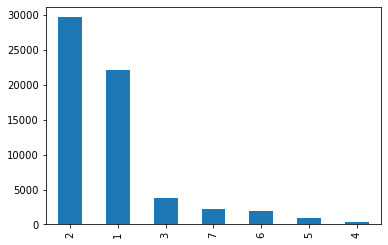

In [6]:
# Explore distribution of dependent variable
train_df["Cover_Type"].value_counts().plot(kind="bar")

We see that the number of observations is asymmetrically distributed across Cover Type classes. Classes 2 and 1 feature by far the most observations, with classes 3, 7, 6, 5 and 4 being underrepresented. It is likely that I will face problems related to class imbalance when fitting my model.

In [7]:
train_df.groupby('Cover_Type').mean()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
Cover_Type,,,,,,,,,,,,
1,3127.691292,156.707690,13.150187,270.667598,42.548448,2614.375693,211.833776,223.290554,143.935177,2005.580567,1.906482,27.735303
2,2920.424756,152.557191,13.550724,279.657932,45.928461,2434.885416,213.644325,225.254395,143.140957,2170.967329,1.946480,24.337184
3,2390.533930,177.589427,21.030510,207.035245,62.784324,954.873488,200.940821,215.494214,140.892425,909.792741,3.605734,6.280116
4,2226.064407,134.827119,18.766102,108.979661,39.752542,899.101695,229.074576,217.322034,110.867797,890.955932,4.000000,6.942373
5,2788.074597,142.457661,16.726815,212.052419,50.788306,1320.293347,223.027218,218.536290,121.822581,1580.823589,2.201613,21.672379
6,2423.493834,181.396247,19.224129,160.767292,46.492761,1039.336729,192.275067,209.653619,148.604826,1062.651475,3.553351,10.263271
7,3359.337494,152.647712,14.281553,351.921868,68.563107,2744.652797,217.359686,221.402681,134.176144,2086.322700,2.382339,36.439205


Looking at the mean of each variable by Cover Type, we see that the means of the regressors differ across classes. This variation across classes will allow me to build a model that predicts the Cover Type.

1         AxesSubplot(0.1,0.559091;0.173913x0.340909)
2    AxesSubplot(0.308696,0.559091;0.173913x0.340909)
3    AxesSubplot(0.517391,0.559091;0.173913x0.340909)
4    AxesSubplot(0.726087,0.559091;0.173913x0.340909)
5             AxesSubplot(0.1,0.15;0.173913x0.340909)
6        AxesSubplot(0.308696,0.15;0.173913x0.340909)
7        AxesSubplot(0.517391,0.15;0.173913x0.340909)
dtype: object

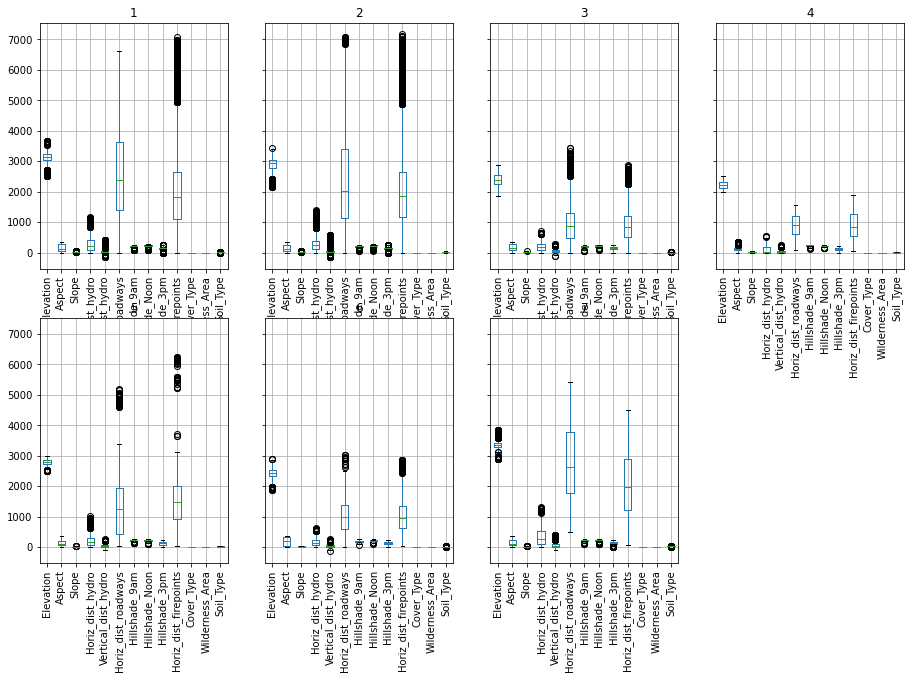

In [8]:
# Examine if the distributions of predictors look different for each class
train_df.groupby("Cover_Type").boxplot(rot=90, layout=(2,4),figsize=(15,10))

This also holds for the distribution of variables across classes. As depicted by the boxplots, variables are distributed differently for the different Cover Type classes.

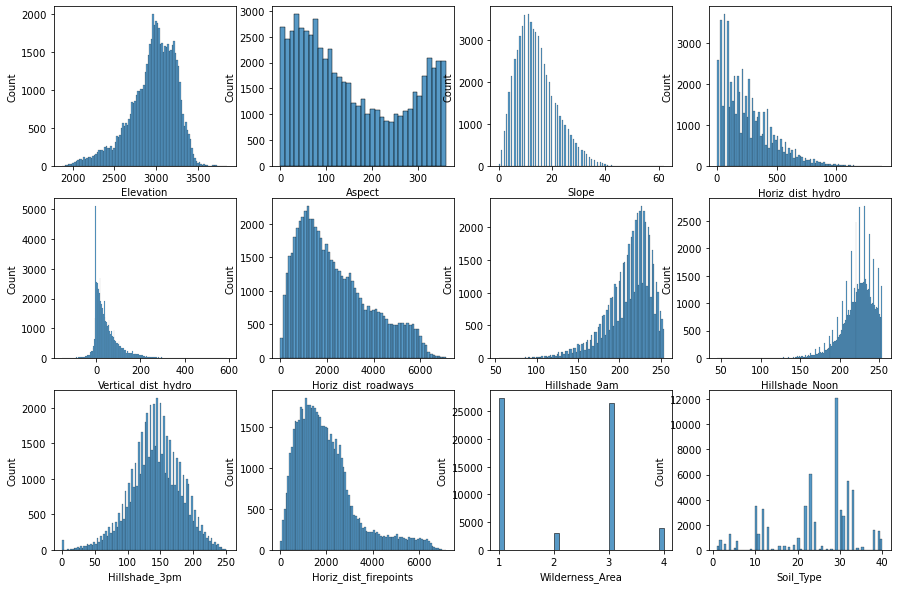

In [9]:
# Look at which features we have from our data set and how they are distributed
fig, axes = plt.subplots(nrows = 3, ncols = 4) 
axes = axes.flatten()        
fig.set_size_inches(15, 10)

train_features = train_df.columns.drop('Cover_Type')

for ax, col in zip(axes, train_features):
  sns.histplot(train_df[col], ax = ax)

The histograms of the regressors show that we have 2 categorical variables: Wilderness Area and Soil Type. Some of the other distributions such as elevation, slope, the distance variables, and hillshade are skewed. It might be worth taking the logs of these variables to remove the skewness.

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

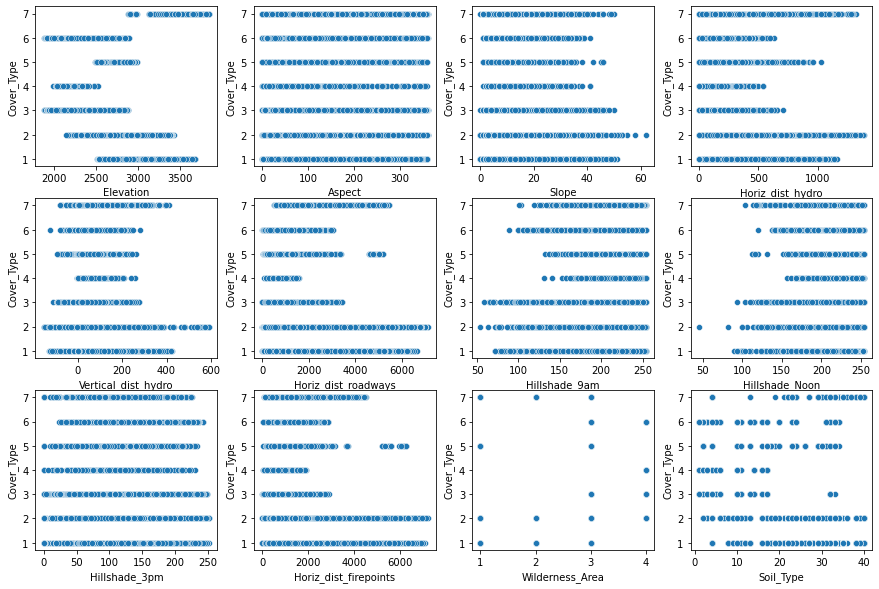

In [10]:
# Check for potential non-linearities
fig, axes = plt.subplots(nrows = 3, ncols = 4) 
axes = axes.flatten()        
fig.set_size_inches(15, 10)

for ax, col in zip(axes, train_features):
  sns.scatterplot(train_df[col], train_df['Cover_Type'], ax = ax)

Plotting each variable against Cover Type, we see that we have nonlinear relationships. This is particularly true for elevation and the distance variables. I tried to fit polynomial features. However, this repeatedly killed my kernel. I will thus not pursue this further.

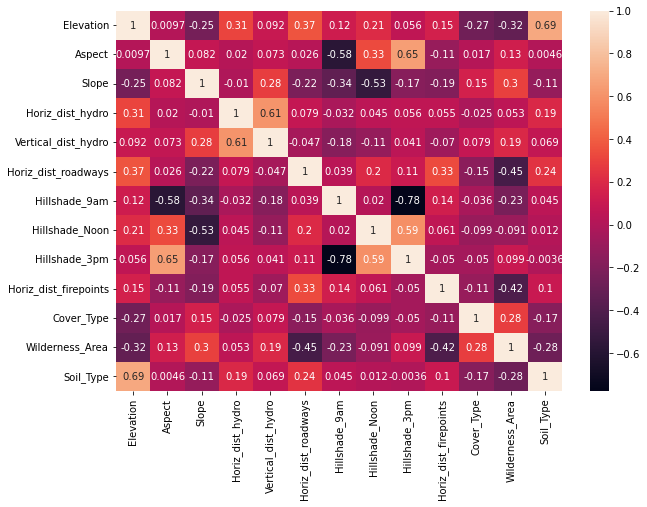

In [11]:
# Correlation matrix
plt.figure(figsize=(10,7))
corrplot = sns.heatmap(train_df.corr(), annot=True)

If we look at the row that shows the correlation between Cover Type and our regressors, we find particularly strong correlations for elevation, slope, horizontal distance to roadways, horizontal distance to firepoints, wilderness area and soil type. If we were to fit a linear model rather than a linear classification, these variables would be particularly relevant for predicting our dependent variable. However, this does not hold for Logistic Regression.

## Step 2: Create dummies for relevant features

In [12]:
# Create dummies from helper functions in library
from src.forest_cover_classification_library.preprocessing import get_dummies

features = ['Wilderness_Area', 'Soil_Type']
train_dummies, test_dummies = get_dummies(train_df, test_df, features)

In [13]:
train_dummies.head()
test_dummies.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,3111,72,13,283,76,630,235,214,109,499,...,1,0,0,0,0,0,0,0,0,0
1,2768,0,20,134,26,912,186,198,146,1974,...,0,0,0,0,0,0,0,0,0,0
2,3360,272,13,685,178,4502,185,244,198,2642,...,0,0,0,0,0,0,0,0,1,0
3,2413,0,3,201,18,560,215,233,156,866,...,0,0,0,0,0,0,0,0,0,0
4,2815,54,11,42,9,2313,226,217,123,2866,...,0,0,0,0,0,0,0,0,0,0


### Add log transformations
As could be seen in the histograms of the data exploration section, some of the regressors have skewed distributions. I now take the log of these variables in order to remove some of the skewness. 'Vertical_dist_hydro' is omitted from this transformation as it has negative values.

In [14]:
train_log = train_dummies.copy()
test_log = test_dummies.copy()

log_transform_features = ['Elevation', 'Slope', 'Horiz_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horiz_dist_firepoints']

for col in log_transform_features:
    train_log[col] = np.log(train_log[col]+1)
    test_log[col] = np.log(test_log[col]+1)
    
train_log.head()
test_log.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,8.043021,72,2.639057,5.648974,76,6.447306,5.463832,5.370638,109,6.214608,...,1,0,0,0,0,0,0,0,0,0
1,7.926242,0,3.044522,4.905275,26,6.816736,5.231109,5.293305,146,7.588324,...,0,0,0,0,0,0,0,0,0,0
2,8.119994,272,2.639057,6.530878,178,8.412499,5.225747,5.501258,198,7.879670,...,0,0,0,0,0,0,0,0,1,0
3,7.789040,0,1.386294,5.308268,18,6.329721,5.375278,5.455321,156,6.765039,...,0,0,0,0,0,0,0,0,0,0
4,7.943073,54,2.484907,3.761200,9,7.746733,5.424950,5.384495,123,7.961021,...,0,0,0,0,0,0,0,0,0,0


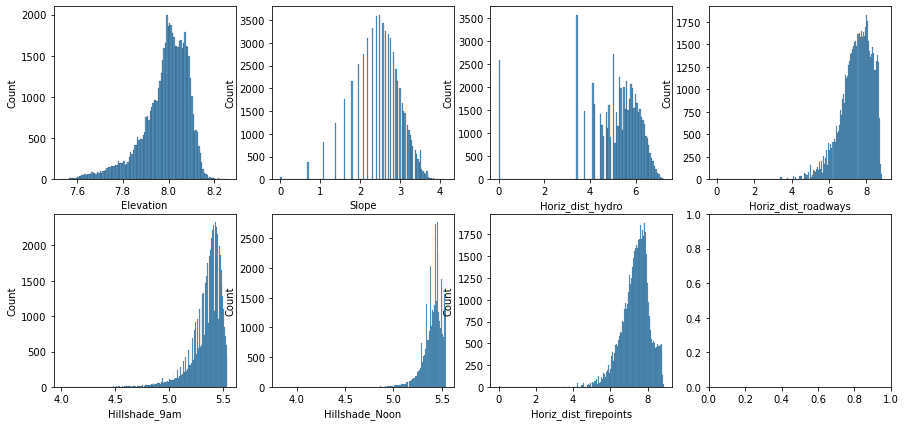

In [15]:
# Look at distribution of transformed features to see if some skewness was removed
fig, axes = plt.subplots(nrows = 2, ncols = 4) 
axes = axes.flatten()        
fig.set_size_inches(15, 7)

for ax, col in zip(axes, log_transform_features):
  sns.histplot(train_log[col], ax = ax)

We see that the log transformation has removed some of the skewness (particularly for slope). Most variables however still exhibit some degree of skewness.

# Binary Model

I ran my model both with and without the log transformation. The log transformation performed better for the binary model and only slightly worse for the multiclass. I will therefore stick to log-transformed features. 

## Step 3: Reformat the data to have an binary class target (class #7 is the target to predict)

In [16]:
train_binary = train_log.copy()
test_binary = test_log.copy()

# Make a binary variable for class 7 Forest Cover
train_binary['class7'] = train_binary.Cover_Type.apply(lambda x: 1 if x == 7 else 0)
train_binary.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,class7
0,8.071843,34,2.397895,0.000000,0,7.923348,5.393628,5.389072,134,7.458763,...,0,0,0,0,0,0,1,0,0,0
1,8.043663,251,2.639057,5.262690,40,8.630700,5.257495,5.521461,195,7.846199,...,0,0,0,0,0,0,0,0,0,0
2,7.938089,77,2.302585,6.236370,17,7.455298,5.451038,5.411646,122,6.992096,...,0,0,0,0,0,0,0,0,0,0
3,8.060224,82,2.302585,5.768321,56,8.495152,5.455321,5.420535,124,7.281386,...,0,0,0,0,0,0,0,0,0,0
4,8.022569,333,2.484907,4.828314,31,7.945910,5.283204,5.424950,170,6.502790,...,0,0,0,0,0,0,0,0,0,0


## Step 4: Build a binary model to predict class #7

In [17]:
X_train = train_binary.drop(columns=['class7', 'Cover_Type']) ## features everything except the Cover_Type column and our dependent binary variable
y_b_train = train_binary['class7']

X_test = test_binary

# to print stats
feature_names = X_train.columns
class_labels_b = ["other class","class 7"] # meant to represent 0 and 1

In [19]:
# Standardisation of predictors
from src.forest_cover_classification_library.preprocessing import scale
X_train, X_test = scale(X_train, X_test)

In [20]:
# Instantiate Logistic Regression function
from sklearn.linear_model import LogisticRegression

model_b1 = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

In [21]:
# Fit logistic regression
model_b1.fit(X_train,y_b_train)

y_b_train_hat = model_b1.predict(X_train)
print(y_b_train_hat)

[1 0 0 ... 0 0 0]


In [22]:
# Compute the predicted probabilities in-sample
y_b_train_prob = model_b1.predict_proba(X_train)
y_b_train_prob 

array([[2.81233970e-01, 7.18766030e-01],
       [9.99870330e-01, 1.29669579e-04],
       [9.99999784e-01, 2.15791327e-07],
       ...,
       [9.98806565e-01, 1.19343502e-03],
       [9.99990435e-01, 9.56459251e-06],
       [9.99999745e-01, 2.54956693e-07]])

## Step 5: Assess expected accuracy

[[58418   425]
 [  934  1229]]


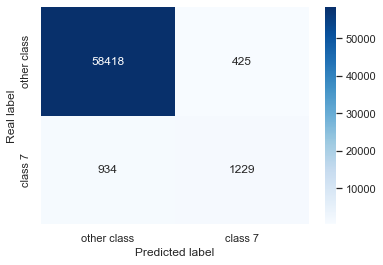

In [24]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix
from src.forest_cover_classification_library.evaluation import plot_confusion_matrix

cm =  confusion_matrix(y_pred=y_b_train_hat, y_true=y_b_train, labels=[0,1])
print (cm)

plot_confusion_matrix(cm, class_labels_b)

The confusion marix shows that we face a class imbalance problem. Our model is bad at correctly predicting class 7. I will address this at a later stage.

AUC:  0.9786497303696683


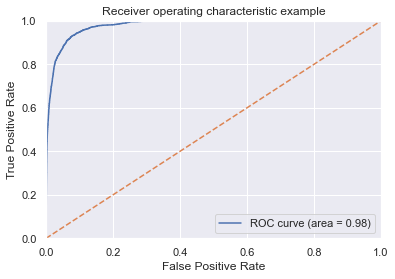

In [26]:
# Accuracy of simple regression model
from src.forest_cover_classification_library.evaluation import get_auc
get_auc(y_b_train, y_b_train_prob, class_labels_b)

Cross-validation allows me to test how well the model would perform out-of-sample. I resample my training set using different portions of the data and then iteratively use these portions to test and train my model.

AUC:  0.9774125665930237


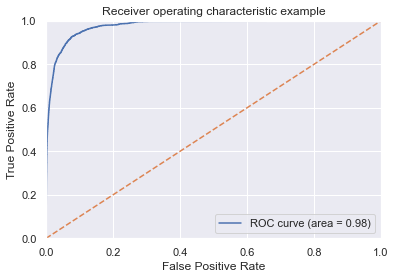

In [27]:
# Cross-validate
from sklearn.model_selection import cross_val_predict
 
y_b_train_hat_cvp = cross_val_predict(model_b1, X_train, y_b_train, cv = 5) ## 5 fold cross validation to predict
y_b_train_prob_cvp = cross_val_predict(model_b1, X_train, y_b_train, method='predict_proba', cv = 5)

get_auc(y_b_train, y_b_train_prob_cvp, class_labels_b)

The cross-validated AUC is only modestly lower than the in-sample score. This indicates that the model will likely perform similarly out-of-sample.

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_b_train, y_b_train_hat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     58843
           1       0.74      0.57      0.64      2163

    accuracy                           0.98     61006
   macro avg       0.86      0.78      0.82     61006
weighted avg       0.98      0.98      0.98     61006



### Hyperparameter Optimisation

In [30]:
# Hyperparameter optimisation using RandomizedSearchCV
from src.forest_cover_classification_library.modelling import tune_hyperparams

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001],
    'max_iter': [1000]
}

tune_hyperparams(model_b1, X_train, y_b_train, param_grid, scoring = 'roc_auc')

# Output: 
# Best: 0.977554 using {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 1.0}

0.977380 (0.001977) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 1000}
0.968410 (0.002663) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.01}
0.971477 (0.002146) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.01}
0.977240 (0.002041) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 1000, 'C': 1000}
0.977522 (0.001948) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 10}
0.977437 (0.001961) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}
0.977554 (0.001958) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 1.0}
0.977429 (0.001958) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}
0.960513 (0.002165) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.001}
0.971477 (0.002147) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.01}
Best: 0.977554 using {'solver': 'liblinear', 'penalt

I refrain from using 'sag' and 'saga' as solvers in my hyperparameter tuning, as they take a lot of time.
Comparing the different outputs, we see that hyperparamter optimization (i.e. tuning the solver and C) only has an incremental effect on the AUC score.

AUC:  0.9784856321203083


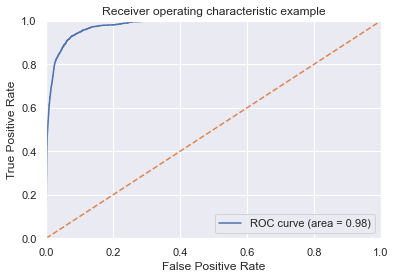

In [31]:
# Rerun Logistic Regression with tuned parameters
model_b2 = LogisticRegression(solver="liblinear", penalty="l2", max_iter=1000, C=1.0) 

model_b2.fit(X_train, y_b_train)
y_b_train_hat_tuned = model_b2.predict(X_train)
y_b_train_prob_tuned = model_b2.predict_proba(X_train)

get_auc(y_b_train, y_b_train_prob_tuned, class_labels_b)
# no improvement to previous model
# solver seems to be more or less irrelevant (different ones chosen by RandomizedGridSearch with similar scores)

AUC:  0.9775409161573991


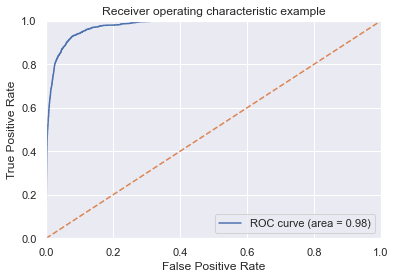

In [32]:
# Cross-validate model
y_b_train_prob_tuned_cvp = cross_val_predict(model_b2, X_train, y_b_train, method='predict_proba', cv = 5)
y_b_train_hat_tuned_cvp = cross_val_predict(model_b2, X_train, y_b_train, cv = 5)

get_auc(y_b_train, y_b_train_prob_tuned_cvp, class_labels_b)

Comparing the AUC scores from our initial model with those after having tuned the hyperparameters, we can see that our in-sample AUC score decreases slightly, whereas the cross-validated AUC increases slightly for the tuned model. However, the changes are incremental. Hyperparameter tuning seems to be almost irrelevant for improving our model.
Given that I want my predictions to be valid out-of-sample, I choose to proceed with the tuned model given that these predictions perform slightly better in cross-validation.

In [33]:
print (classification_report(y_b_train, y_b_train_hat_tuned))
# The classification report does not change.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     58843
           1       0.74      0.56      0.64      2163

    accuracy                           0.98     61006
   macro avg       0.86      0.78      0.82     61006
weighted avg       0.98      0.98      0.98     61006



## Step 6: Report variable impact
I report the coefficients of my tuned model given that this performed slightly better than the original model.

<Figure size 1440x1800 with 0 Axes>

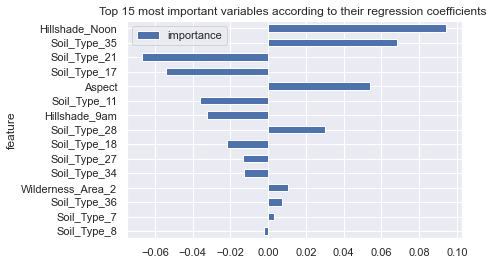

In [34]:
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = model_b2.coef_[0]
feature_importance["importance_abs_value"] = feature_importance["importance"].abs()

feature_importance_top10 = feature_importance.sort_values(by = ["importance_abs_value"], ascending=True).head(15)
 
fig = plt.figure(figsize = (20,25))
ax = feature_importance_top10.plot.barh(x='feature', y='importance', 
                                           title="Top 15 most important variables according to their regression coefficients ")
plt.show()

Given that I have scaled my regressors, the relative size of the coefficients can be interpreted as the relative importance of the respective features. As shown in the figure, Hillshade, Soil Type, Aspect and Wilderness Area are the most important features for predicting Cover Type 7 ("Krummholz").

## Step 7: Try to improve it using methods to tackle class imbalance.

In [35]:
# Train the model correcting for class imbalance
model_b3 = LogisticRegression(C=100, class_weight='balanced', solver='liblinear')

model_b3.fit(X_train,y_b_train)

y_b_train_prob_imb = model_b3.predict_proba(X_train)

forestcover_df_original = pd.read_csv("data/MultiClass_Train.csv")
forestcover_df_original["pred_b_prob"] = y_b_train_prob[:,1] 
forestcover_df_original["pred_b_prob_imb"] = y_b_train_prob_imb[:,1]

In [37]:
# Correct for the biased sample by rescaling the probability
from src.forest_cover_classification_library.modelling import reweight_binary

q1 = y_b_train.sum()/len(y_b_train)
r1 = 0.5

reweighted_probs_b1 = pd.DataFrame(y_b_train_prob_imb).apply(reweight_binary,args=(q1,r1))
reweighted_probs_b1 = reweighted_probs_b1.to_numpy()

AUC:  0.9794030376592597


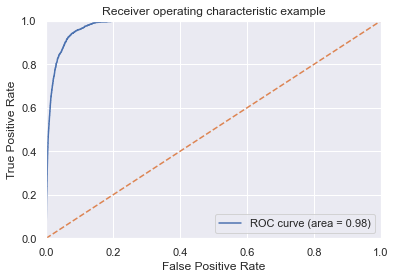

In [38]:
# Get In-sample accuracy
get_auc(y_b_train, reweighted_probs_b1, class_labels_b)

Correcting for class imbalance led to a small improvement in the AUC score.

array([<AxesSubplot:title={'center':'pred_b_prob'}, xlabel='Cover_Type'>,
       <AxesSubplot:title={'center':'pred_b_prob_imb'}, xlabel='Cover_Type'>,
       <AxesSubplot:title={'center':'pred_b_prob_imb_corr'}, xlabel='Cover_Type'>],
      dtype=object)

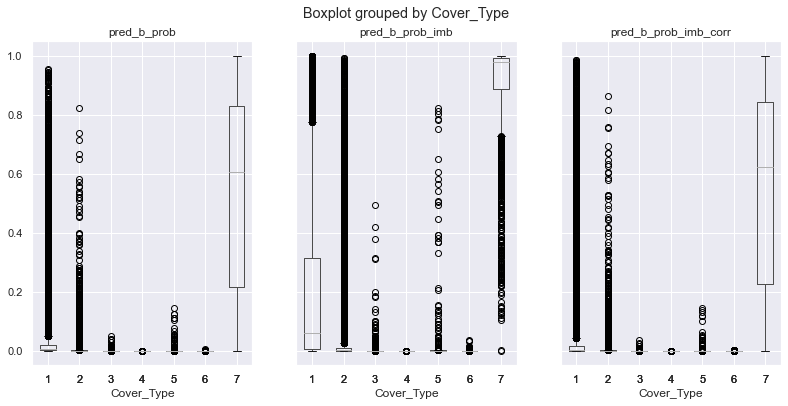

In [39]:
forestcover_df_original["pred_b_prob_imb_corr"] = forestcover_df_original["pred_b_prob_imb"].apply(reweight_binary,args=(q1,r1))
forestcover_df_original.boxplot(["pred_b_prob","pred_b_prob_imb","pred_b_prob_imb_corr"],by="Cover_Type",layout=(1,3), figsize=(13,6))

These boxplots show how we correct for class imbalance by oversampling class 7 observations when we fit our model. The left boxplot shows our initial predicted probabilities for Cover Type. In the middle boxplot we oversample class 7 observations and again predict the probabilities for this Cover Type. We now need to reweight our probabilities to account for the oversampling of class 7 and recover our initial distributions. This is shown in the right boxplot. If we correctly execute the correction for class imbalance, the left and right boxplot should show similar distributions. This is the case.

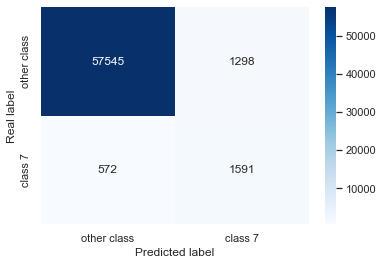

In [40]:
y_b_train_hat_imb_corr = [1 if pi >= 0.25 else 0 for pi in forestcover_df_original["pred_b_prob_imb_corr"] ]

#confusion matrix
cm =  confusion_matrix(y_pred=y_b_train_hat_imb_corr, y_true=y_b_train, labels=[0,1])
plot_confusion_matrix(cm, class_labels_b) 

Comparing this confusion matrix with the one where we did not account for class imbalance, we see that our mispredictions for class 7 have gone down. Correcting for class imbalance has thus increased our ability to accurately predict class 7.

AUC:  0.9782675808556096


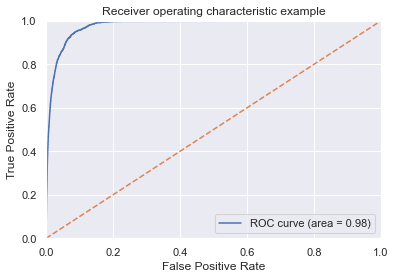

In [41]:
# Report Accuracy Score on cross validated training set
y_b_train_prob_imb_cvp = cross_val_predict(model_b3, X_train, y_b_train, method='predict_proba', cv = 5)

reweighted_probs_b2 = pd.DataFrame(y_b_train_prob_imb_cvp).apply(reweight_binary,args=(q1,r1))
reweighted_probs_b2 = reweighted_probs_b2.to_numpy()

get_auc(y_b_train, reweighted_probs_b2, class_labels_b)

In [42]:
print(classification_report(y_b_train, y_b_train_hat_imb_corr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     58843
           1       0.55      0.74      0.63      2163

    accuracy                           0.97     61006
   macro avg       0.77      0.86      0.81     61006
weighted avg       0.97      0.97      0.97     61006



## Final step: Generate test set predictions

In [43]:
# Without correcting for class imbalance
y_b_test_hat = model_b2.predict(X_test)
y_b_test_prob = model_b2.predict_proba(X_test)

In [44]:
# Correcting for class imbalance
y_b_test_prob_imb = pd.Series(model_b3.predict_proba(X_test)[:,1]).apply(reweight_binary,args=(q1,r1))
y_b_test_prob_imb

0        1.067567e-03
1        1.104977e-07
2        5.478019e-01
3        1.858652e-10
4        1.049139e-05
             ...     
13068    4.607089e-04
13069    1.382339e-04
13070    4.195682e-05
13071    1.322132e-06
13072    2.925345e-01
Length: 13073, dtype: float64

In [45]:
# test_predictions_submit = pd.DataFrame({"Index": test_raw_id, "Cover_Type": y_b_test_hat})
test_predictions_submit = pd.DataFrame({"Index": test_raw_id, "Cover_Type": y_b_test_prob_imb})
test_predictions_submit.to_csv("kaggle/binary_CI_test_LogReg_predictions_submit.csv", index = False)

# Multiclass Model
## Step 4: Build a multiclass model to predict forest cover

In [46]:
# Define features and dependent variable
y_train = train_binary['Cover_Type']

# to print stats
class_labels = ['Cover_Type']

I reuse X_train and X_test from the binary case given that only the dependent variable changes. Both matrices have been scaled for the binary case.

In [47]:
# Instantiate and fit basic Logistic Regression function
from sklearn.linear_model import LogisticRegression
model_m1 = LogisticRegression(multi_class="multinomial",solver="newton-cg",max_iter=10000) 
model_m1.fit(X_train,y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial',
                   solver='newton-cg')

In [48]:
y_train_hat = model_m1.predict(X_train)
y_train_prob = model_m1.predict_proba(X_train)

## Step 5: Assess expected accuracy

[[15545  6221     6     0     3     6   418]
 [ 5453 23670   372     1    31   146    17]
 [    0   404  3045    46     4   303     0]
 [    0     3   116   155     0    21     0]
 [   23   879    27     0    60     3     0]
 [    0   431   899    12    13   510     0]
 [  909    18     0     0     0     0  1236]]


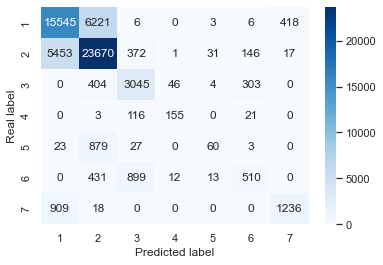

In [49]:
# Make a confusion matrix
cm =  confusion_matrix(y_pred=y_train_hat, y_true=y_train, labels=[1,2,3,4,5,6,7])
print (cm)

plot_confusion_matrix(cm, class_labels=["1","2","3","4","5","6","7"])

The confusion matrix shows evidence of class imbalance. I more frequently mispredict the labels for categories that only feature a small number of observations (i.e. classes 3, 4, 5, 6, 7).

In [50]:
y_train_prob.shape

(61006, 7)

In [51]:
# Calculate the accuracy score
class_labels_multi = []
for i in range(y_train_prob.shape[0]):
    class_labels_multi.append(np.where(y_train_prob[i,:] == np.amax(y_train_prob[i,:]))[0][0]+1)

from sklearn.metrics import accuracy_score
accuracy_score(y_train, class_labels_multi)

0.7248631282168967

In [52]:
# Cross-validation
y_train_prob_cvp = cross_val_predict(model_m1, X_train, y_train, method='predict_proba', cv = 5)
y_train_hat_cvp = cross_val_predict(model_m1, X_train, y_train, cv = 5)

In [53]:
class_labels_multi_cvp = []
for i in range(y_train_prob_cvp.shape[0]):
    class_labels_multi_cvp.append(np.where(y_train_prob_cvp[i,:] == np.amax(y_train_prob_cvp[i,:]))[0][0]+1)
    
accuracy_score(y_train, class_labels_multi_cvp)

0.7235026063010196

### Hyperparameter optimisation
I had a lot of problems running this on my computer. I would expect 'newton-cg' or 'lbfgs' to perform better than 'sag' or 'saga', but unfortunately I couldn't get any ouput for those (either non-convergence or still running after 12 hrs):

In [54]:
# Hyperparameter optimisation using RandomizedSearchCV
from src.forest_cover_classification_library.modelling import tune_hyperparams

param_grid = {
    'solver': ['sag', 'saga'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1],
    'max_iter': [1000]
}

tune_hyperparams(model_m1, X_train, y_train, param_grid, n_iter = 8, scoring = 'accuracy')

# Results:
# Best: 0.723519 using {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 10}
# Execution time: 1693.6665279865265 ms

0.723486 (0.001946) with: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}
0.723404 (0.001998) with: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}
0.723519 (0.001960) with: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 10}
0.723404 (0.001954) with: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 10}
0.723437 (0.002123) with: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 1.0}
0.723421 (0.002132) with: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 1.0}
0.722519 (0.002001) with: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}
0.722437 (0.002017) with: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}
Best: 0.723519 using {'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'C': 10}
Execution time: 476.65172600746155 ms


In [55]:
# Rerun Logistic Regression with tuned parameters
model_m2 = LogisticRegression(multi_class="multinomial",solver="sag", penalty="l2", max_iter=1000, C=10) 
model_m2.fit(X_train, y_train)

y_train_prob_tuned = model_m2.predict_proba(X_train)
y_train_hat_tuned = model_m2.predict(X_train)

In [56]:
class_labels_multi_tuned = []
for i in range(y_train_prob_tuned.shape[0]):
    class_labels_multi_tuned.append(np.where(y_train_prob_tuned[i,:] == np.amax(y_train_prob_tuned[i,:]))[0][0]+1)
    
accuracy_score(y_train, class_labels_multi_tuned)

0.7246008589319083

In [57]:
# Cross-validation
y_train_prob_tuned_cvp = cross_val_predict(model_m2, X_train, y_train, method='predict_proba', cv = 5)
y_train_hat_tuned_cvp = cross_val_predict(model_m2, X_train, y_train, cv = 5)

In [58]:
class_labels_multi_tuned_cvp = []
for i in range(y_train_prob_tuned_cvp.shape[0]):
    class_labels_multi_tuned_cvp.append(np.where(y_train_prob_tuned_cvp[i,:] == np.amax(y_train_prob_tuned_cvp[i,:]))[0][0]+1)
    
accuracy_score(y_train, class_labels_multi_tuned_cvp)

0.7235189981313314

As in the binary case, the tuned model performs slightly worse in-sample and slightly better for cross-validation. However, the differences are almost insignificant. I will stick to the tuned parameters given that out-of-sample testing is more relevant for assessing the performance of the model.

## Step 6: Report variable impact

Feature importance for Cover Type 1 :


<Figure size 1440x1800 with 0 Axes>

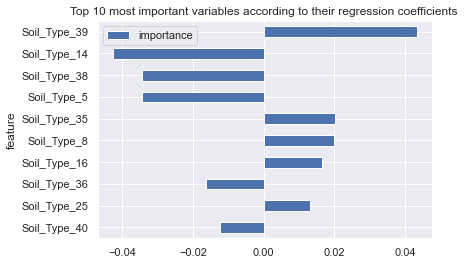

Feature importance for Cover Type 2 :


<Figure size 1440x1800 with 0 Axes>

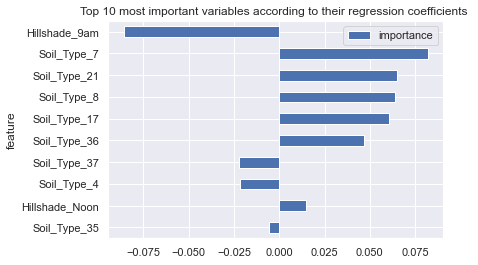

Feature importance for Cover Type 3 :


<Figure size 1440x1800 with 0 Axes>

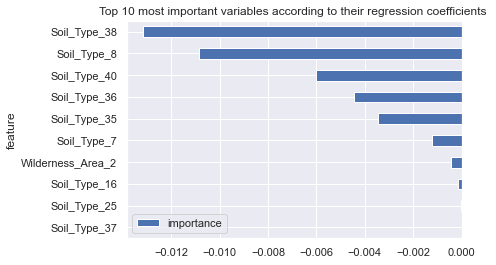

Feature importance for Cover Type 4 :


<Figure size 1440x1800 with 0 Axes>

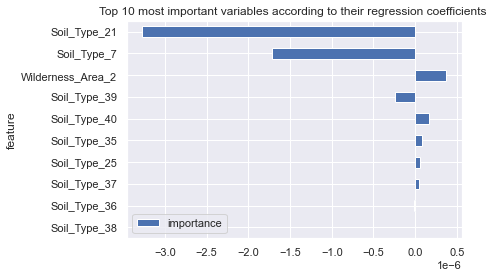

Feature importance for Cover Type 5 :


<Figure size 1440x1800 with 0 Axes>

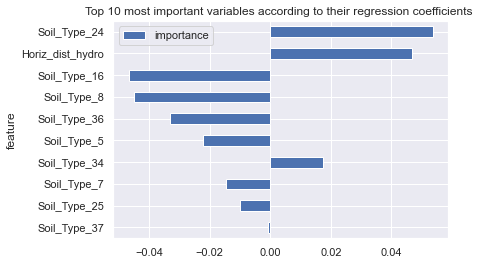

Feature importance for Cover Type 6 :


<Figure size 1440x1800 with 0 Axes>

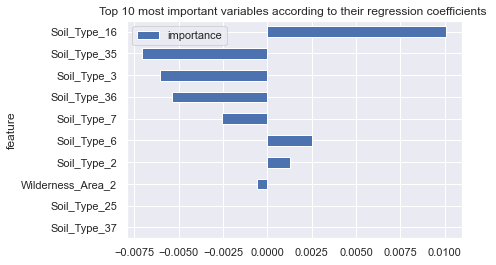

Feature importance for Cover Type 7 :


<Figure size 1440x1800 with 0 Axes>

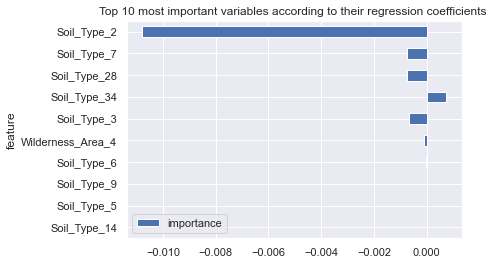

In [59]:
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
for i in range(7):
    print("Feature importance for Cover Type", i+1, ":")
    feature_importance["importance"] = model_m1.coef_[i]
    feature_importance["importance_abs_value"] = feature_importance["importance"].abs()

    feature_importance_top10 = feature_importance.sort_values(by = ["importance_abs_value"], ascending=True).head(10)

    fig = plt.figure(figsize = (20,25))
    ax = feature_importance_top10.plot.barh(x='feature', y='importance', 
                                               title="Top 10 most important variables according to their regression coefficients ")
    plt.show()

## Step 7: Try to improve it using methods to tackle class imbalance.

In [60]:
# Train the model correcting for class imbalance
model_m3 = LogisticRegression(class_weight='balanced', multi_class="multinomial", solver="sag", penalty="l2", max_iter=1000, C=10)
model_m3.fit(X_train,y_train)

y_train_hat_imb = model_m3.predict(X_train)
y_train_prob_imb = model_m3.predict_proba(X_train)

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [61]:
# Correct for the biased sample by rescaling the probability
from src.forest_cover_classification_library.modelling import reweight_multi
freq = pd.Series(y_train.value_counts())
q = []
for i in range(1, len(freq)+1):
    a = freq[i]/len(y_train)
    q.append(a)    

r = 1/7

y_prob_imb_corr = reweight_multi(pd.DataFrame(y_train_prob_imb),q,r)

[[14567  3898     8     0   869   117  2740]
 [ 6726 15684   500    18  5222  1222   318]
 [    0    20  2159   417   184  1022     0]
 [    0     0    21   265     0     9     0]
 [   12   154    19     0   763    44     0]
 [    0    18   412    95    69  1271     0]
 [  231     0     0     0    12     0  1920]]


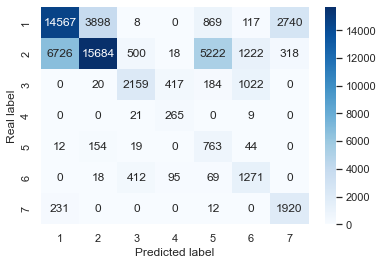

In [62]:
# Make a confusion matrix
cm =  confusion_matrix(y_pred=y_train_hat_imb, y_true=y_train, labels=[1,2,3,4,5,6,7])
print (cm)

plot_confusion_matrix(cm, class_labels=["1","2","3","4","5","6","7"])

The confusion matrix shows that class imbalance has been reduced.

In [63]:
class_labels_multi_imb = []
for i in range(y_train_prob_imb.shape[0]):
    class_labels_multi_imb.append(np.where(y_train_prob_imb[i,:] == np.amax(y_train_prob_imb[i,:]))[0][0]+1)
    
accuracy_score(y_train, class_labels_multi_imb)

0.600416352489919

In [64]:
# Cross-validation
y_train_prob_imb_cvp = cross_val_predict(model_m3, X_train, y_train, method='predict_proba', cv = 5)
y_train_hat_imb_cvp = cross_val_predict(model_m3, X_train, y_train, cv = 5)

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/phi

In [65]:
class_labels_multi_imb_cvp = []
for i in range(y_train_prob_imb_cvp.shape[0]):
    class_labels_multi_imb_cvp.append(np.where(y_train_prob_imb_cvp[i,:] == np.amax(y_train_prob_imb_cvp[i,:]))[0][0]+1)
    
accuracy_score(y_train, class_labels_multi_imb_cvp)

0.5997606792774481

Whilst we are now better at predicting small classes, the accuracy of our overall model has declined. This is in line with my expectations.

## Final step: generate test set predictions

In [66]:
y_test_hat = model_m2.predict(X_test)
y_test_prob = model_m2.predict_proba(X_test)
print(y_test_hat)
print(y_test_prob)

[1 2 7 ... 2 2 1]
[[5.77829895e-01 4.07827552e-01 1.42970232e-06 ... 1.14823756e-02
  3.63093567e-05 2.82242230e-03]
 [1.49172061e-01 8.04686568e-01 7.13054195e-03 ... 8.77397612e-03
  3.02271043e-02 9.57284563e-06]
 [3.86889103e-01 2.29070755e-02 1.50173087e-05 ... 1.01794189e-05
  2.16384406e-05 5.90156951e-01]
 ...
 [3.26926935e-01 6.69500569e-01 8.81240495e-06 ... 3.46211761e-03
  2.44912891e-06 9.84395713e-05]
 [1.16831823e-01 8.49098198e-01 8.65510692e-03 ... 5.97279271e-03
  1.94180664e-02 4.19471844e-06]
 [6.85975909e-01 2.80943857e-02 5.25146318e-08 ... 1.26328664e-06
  1.44233818e-08 2.85928374e-01]]


### Test set predictions correcting for class imbalance

In [67]:
y_test_prob_imb = model_m3.predict_proba(X_test)

class_labels_multi_imb_test = []
for i in range(y_test_prob_imb.shape[0]):
    class_labels_multi_imb_test.append(np.where(y_test_prob_imb[i,:] == np.amax(y_test_prob_imb[i,:]))[0][0]+1)
    
# print(class_labels_multi_imb_test)

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "Index"'s and the other with your probability of the "Covert_Type" being class 7

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [68]:
# Kaggle Prediction Submissions - Not Correcting for class imbalance
test_predictions_submit = pd.DataFrame({"Index": test_raw_id, "Cover_Type": y_test_hat})
test_predictions_submit.to_csv("kaggle/multiclass_CI_test_LogReg_predictions_submit.csv", index = False)

In [69]:
# Kaggle Prediction Submissions - Correcting for class imbalance
test_predictions_submit = pd.DataFrame({"Index": test_raw_id, "Cover_Type": class_labels_multi_imb_test})
test_predictions_submit.to_csv("kaggle/multiclass_imb_CI_test_LogReg_predictions_submit.csv", index = False)